# This is a demonstration notebook for solving inverse AFC plate problem

I will add relevant formulas here later :D

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import jax
import jax.numpy as jnp

from jax_plate.Problem import Problem
from jax_plate.Utils import *
from jax_plate.Optimizers import optimize_trust_region, optimize_gd

%matplotlib inline
import matplotlib.pyplot as plt

### Set material parameters

The geometry, location of test point and loading function are defined in `_problem.edp`. I will change it later when we decide on the format of mesh/geometry, comfortable to the experimental guys

In [2]:
# Aluminum triangle from tuan2015chladni
rho = 2670. # [kg/m^3]
E = 69*1e9 # [Pa]
nu = 0.32 # [1]
h = 1e-3 # [m]
D = E*h**3/(12.*(1. - nu**2))
# this value i don't know
beta = .01 # loss factor, [1]

p = Problem("_problem.edp", h, rho)
get_afc = p.getAFCFunction(isotropic_to_full)

In [ ]:
freqs = jnp.linspace(1, 200, 201, endpoint=True)
params = jnp.array([D, nu, beta])

ref_afc = get_afc(freqs, params)

In [ ]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)

axs[0].plot(freqs, ref_afc[:, 0])
axs[0].grid(True)
axs[1].plot(freqs, ref_afc[:, 1])
axs[1].grid(True)

In [ ]:
afc_module = jnp.linalg.norm(ref_afc, axis=1, ord=2)

afc_phase_shift = jnp.arctan2(ref_afc[:, 0], ref_afc[:, 1])/jnp.pi

fig, axs = plt.subplots(figsize=(20, 10), nrows=1, ncols=2)

axs[0].set_yscale('log')
axs[0].plot(freqs, afc_module)
axs[0].set_title(r"$\|u\|$")
axs[0].grid(True)

axs[1].plot(freqs, afc_phase_shift)
axs[1].set_title("Phase shift / pi")
axs[1].grid(True)

Testing if gradient works

In [ ]:
mse_loss = p.getMSELossFunction(isotropic_to_full, freqs, ref_afc)

lam_tikhonov = 1e-1
def regularized_loss(params):
    return mse_loss(params) + lam_tikhonov*jnp.linalg.norm(params, ord=2)


loss_and_grad = jax.jit(jax.value_and_grad(regularized_loss))
hessian = jax.hessian(regularized_loss)
other_params = params*jnp.array([0.9, 1.1, 1.1])
loss_and_grad(other_params)

## Test the optimization

In [7]:
freqs = jnp.linspace(1, 200, 201, endpoint=True)

ref_params = jnp.array([D, nu, beta])
start_params = ref_params*jnp.array([0.97, 1.05, 0.97])

getAFC = p.getAFCFunction(isotropic_to_full)
ref_afc = getAFC(freqs, ref_params)


mse_loss = p.getMSELossFunction(isotropic_to_full, freqs, ref_afc)

opt_result = optimize_gd(mse_loss, start_params, h=1e-3, N_steps=300,  )

In [ ]:
(opt_result.x - ref_params)/ref_params, opt_result.f

In [ ]:
opt_result.x

In [ ]:
plt.plot(opt_result.f_history)
plt.yscale('log')
plt.grid(True)

In [ ]:
opt_result.status

In [ ]:
optimized_afc = getAFC(freqs, opt_result.x)

In [ ]:
fig, axs = plot_afc(freqs, ref_afc, label='Reference', kind='Radial')
plot_afc(freqs, optimized_afc, label='Optimized', fig=fig)


In [ ]:
gh = jnp.array(opt_result.grad_history)
gh = jnp.abs(gh)

plt.yscale('log')
labels = ['D', 'nu', 'beta']
for i in range(3):
    plt.plot(gh[:, i], label=labels[i])
plt.legend()
plt.grid()

In [ ]:
xh = jnp.array(opt_result.x_history)

#re_h = jnp.abs((xh - ref_params)/ref_params)
re_h = (xh - ref_params)/ref_params

#plt.yscale('log')
labels = ['D', 'nu', 'beta']
for i in range(3):
    plt.plot(re_h[100:, i], label=labels[i])
plt.legend()
plt.grid()

In [20]:
def vary_one_parameter(k: int):
    return lambda _p: isotropic_to_full(ref_params.at[k].set(_p))

In [22]:
freqs = jnp.linspace(1, 100, 201, endpoint=True)
ref_afc = getAFC(freqs, ref_params)
loss_1d = p.getMSELossFunction(vary_one_parameter(0), freqs, ref_afc)
eval_losses = jax.jit(lambda _ps : [loss_1d(_p) for _p in _ps])

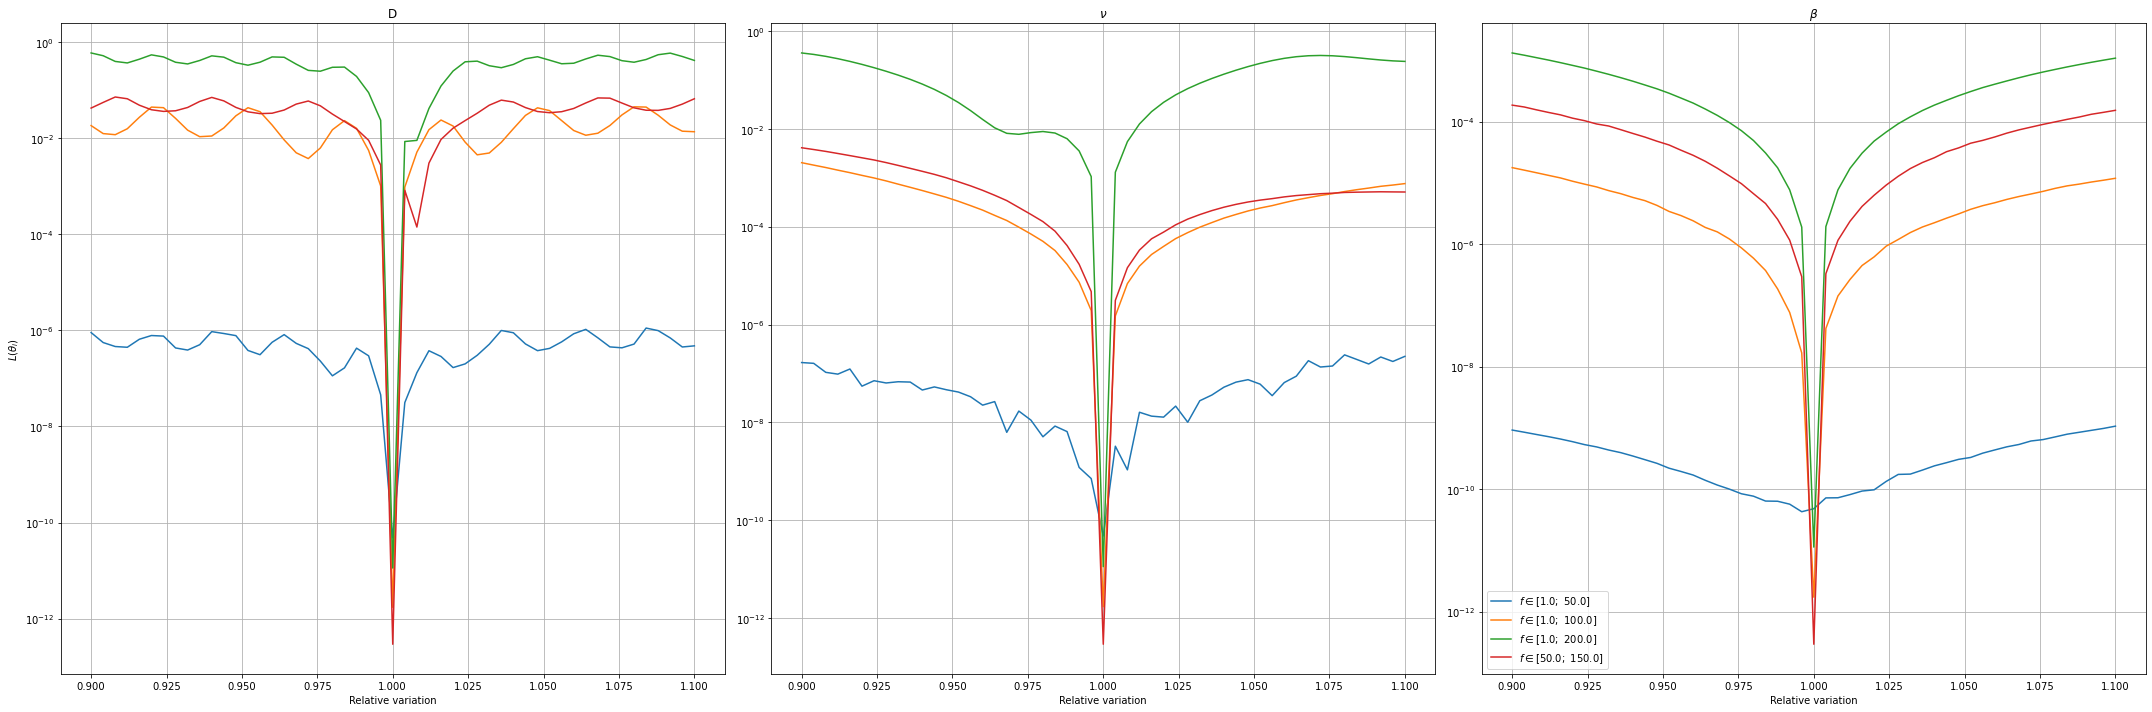

In [47]:
fig, axs = plt.subplots(figsize=(30, 10), nrows=1, ncols=3, sharex=True, sharey='col')

ref_params = jnp.array([D, nu, beta])
param_fractions = jnp.linspace((1. - 0.1), (1. + 0.1), 51, endpoint=True)
getAFC = p.getAFCFunction(isotropic_to_full)

frequency_ranges = [(1, 50), (1, 100), (1, 200), (50, 150)]

for jdx, frange in enumerate(frequency_ranges):
    freqs = jnp.linspace(*frange, 101, endpoint=True)
    ref_afc = getAFC(freqs, ref_params)
    for idx, par_name in enumerate(['D', '$\\nu$', '$\\beta$']):
        loss_1d = p.getMSELossFunction(vary_one_parameter(idx), freqs, ref_afc)
        eval_losses = jax.jit(lambda _ps : [loss_1d(_p) for _p in _ps])
        ref_value = ref_params[idx]
        varied_values = ref_value*param_fractions
        losses = eval_losses(varied_values)
        ax = axs[idx]
        ax.plot(param_fractions + 1e-12, losses, color=f'C{jdx}', label=f'$f \\in [{frange[0]:.1f};\ {frange[1]:.1f}]$')
        ax.set_yscale('log')
        ax.grid(True)
        if idx == 0:
            ax.set_ylabel("$L(\\theta_i)$")
        if jdx == 0:
            ax.set_title(par_name)
        if jdx == 1:
            ax.set_xlabel('Relative variation')
        if idx == 2:
            ax.legend()
        
        
        
fig.tight_layout()

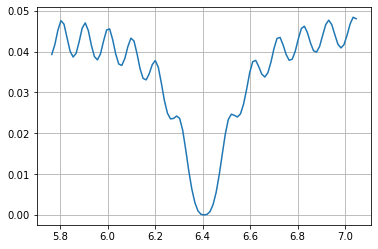

In [24]:
fig, axs = plot

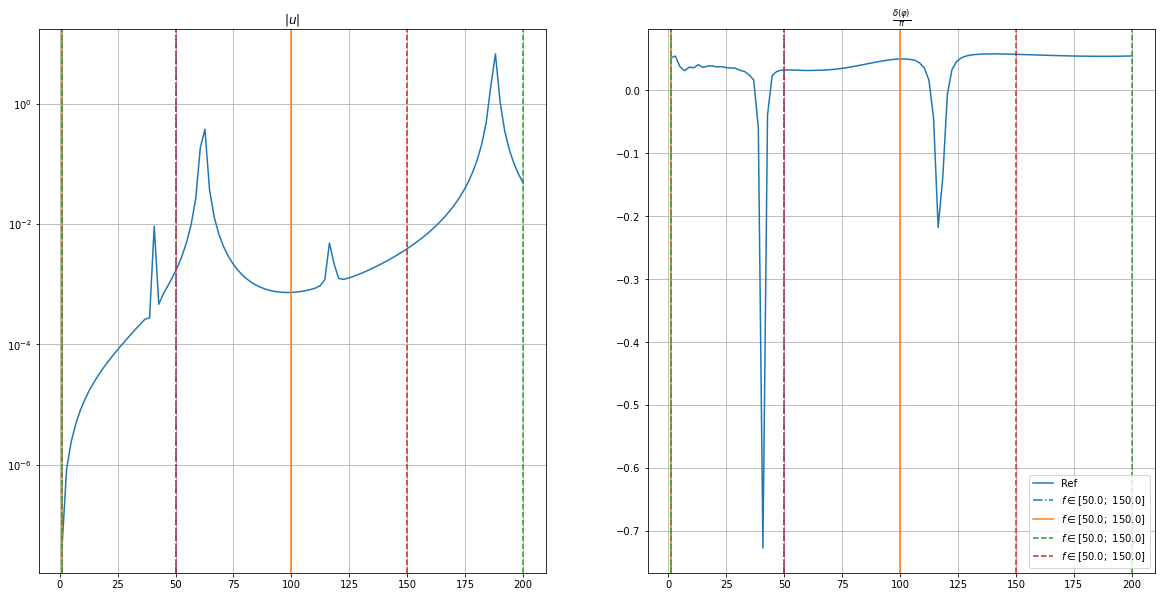

In [46]:
freqs = jnp.linspace(1, 200, 101, endpoint=True)
ref_afc = getAFC(freqs, ref_params)
fig, axs = plot_afc(freqs, ref_afc, label='Ref', kind='Radial')
frequency_ranges = [(1, 50), (1, 100), (1, 200), (50, 150)]
linestyles = ['-.', '-', '--', '--']
for idx, fr in enumerate(frequency_ranges):
    for ax in axs:
        ax.axvline(fr[0], color=f'C{idx}', linestyle=linestyles[idx])
        
        ax.axvline(fr[1], color=f'C{idx}', linestyle=linestyles[idx], label=f'$f \\in [{frange[0]:.1f};\ {frange[1]:.1f}]$')
        
axs[1].legend()